In [16]:
import os
import json
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

RUN_ID = 'run_combined'

# Path to search for captain.json files
base_path = f'/home/ubuntu/new_battleship/battleship/experiments/collaborative/captain_benchmarks/{RUN_ID}/rounds/'

# Find all captain.json files in subdirectories
captain_files = glob.glob(os.path.join(base_path, '**/captain/captain.json'), recursive=True)

# Dictionary to store eig values by file
eig_values_by_file = {}
# Initialize list to store data for DataFrame
eig_data_list = []

# Extract eig values from each file
for file_path in captain_files:
    # Get relative path for naming
    rel_path = os.path.relpath(file_path, base_path)
    
    # Extract round_id from path
    round_id = rel_path.split('/')[0].split('_')[1]
    
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            
        # Extract eig values, skipping None/null values
        for idx, datum in enumerate(data):
            if 'eig' in datum and datum['eig'] is not None and 'question' in datum and datum['question'] is not None:
                question_text = datum['question']['question']['text'] if datum['question']['question'] and 'text' in datum['question']['question'] else "No question text"
                eig_value = datum['eig']
                
                eig_questions = datum.get("eig_questions", [])

                if len(eig_questions) != 0:
                    eig_questions = [(q['question']['question']['text'],q['eig'], None) for q in eig_questions]
                    max_eig = max([eq[1] for eq in eig_questions if eq[1] is not None])
                    eig_questions = [(q[0], q[1], q[1] == max_eig) for q in eig_questions]

                # Add to data list
                eig_data_list.append({
                    'round_id': round_id,
                    'question_idx': idx,
                    'question': question_text,
                    'eig': eig_value,
                    'eig_questions': eig_questions,
                })
                
    except (json.JSONDecodeError, FileNotFoundError, KeyError, TypeError) as e:
        print(f"Error processing {file_path}: {e}")

# Create DataFrame from the list
eig_df = pd.DataFrame(eig_data_list)

# Also maintain the old dictionary for backward compatibility
for file_path in captain_files:
    rel_path = os.path.relpath(file_path, base_path)
    round_specific_eigs = eig_df[eig_df['round_id'] == rel_path.split('/')[0].split('_')[1]]['eig'].tolist()
    if round_specific_eigs:
        eig_values_by_file[rel_path] = round_specific_eigs

In [17]:
eig_df

,round_id,question_idx,question,eig,eig_questions
0,a272e18b,1,Is there at least one ship tile in columns 1 t...,0.130059,[]
1,a272e18b,3,Is there at least one ship tile in rows A thro...,0.560174,[]
2,a272e18b,5,Is there at least one ship tile in columns 5 t...,0.087352,[]
3,a272e18b,7,Is there at least one ship tile in rows A thro...,0.546365,[]
4,a272e18b,9,Is there at least one ship tile in rows E thro...,0.100082,[]
...,...,...,...,...,...
1199,a6aa601c,33,Is the Green ship located entirely within colu...,0.995144,"[(Does the Purple ship occupy A6?, 0.967332433..."
1200,a6aa601c,35,Does the Purple ship occupy any tile in column 6?,0.965442,"[(Is the green ship located in column 1 or 2?,..."
1201,a6aa601c,39,Does the Green ship occupy any tile in columns...,0.936719,[(Does the Green ship occupy any tile in colum...
1202,a6aa601c,41,Does the Orange ship occupy any tile in rows A–D?,0.999166,[(Does the Orange ship occupy any tile in colu...


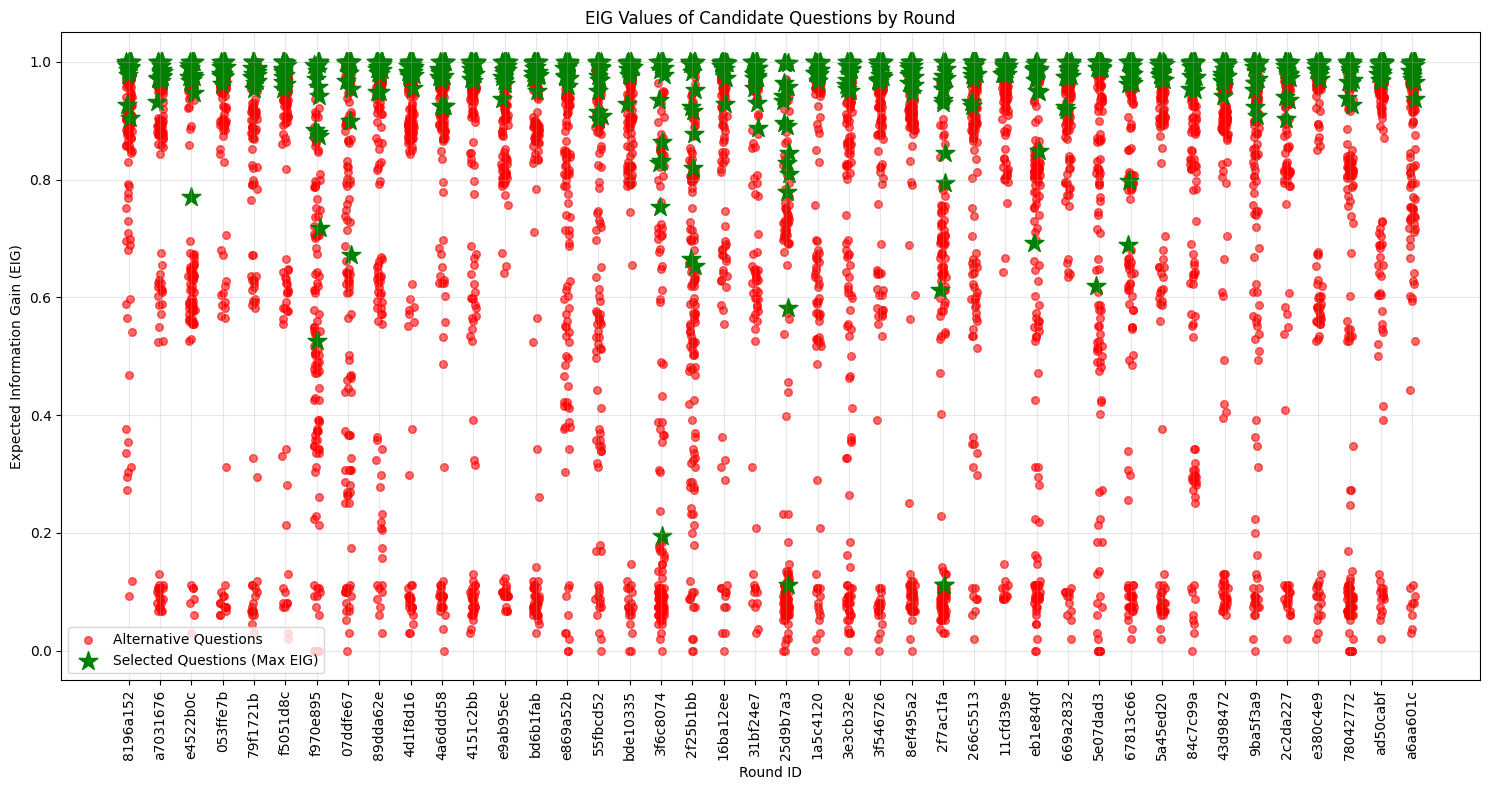

Total candidate questions: 6300
Number of selected questions (max EIG): 659
Average EIG of selected questions: 0.9698
Average EIG of alternative questions: 0.7317


In [33]:
# Create a new dataframe where each row contains a round_id and a question from eig_questions
expanded_df = []

for _, row in eig_df.iterrows():
    # Only process rows that have eig_questions
    if row['eig_questions'] and len(row['eig_questions']) > 0:
        for question, eig_value, is_max in row['eig_questions']:
            expanded_df.append({
                'round_id': row['round_id'],
                'parent_question': row['question'],
                'parent_eig': row['eig'],
                'candidate_question': question,
                'candidate_eig': eig_value,
                'is_max_eig': is_max
            })

# Create the dataframe
eig_questions_df = pd.DataFrame(expanded_df)

# Display the first few rows
eig_questions_df

# Merge with df_combined to get captain_type for each question
enriched_df = pd.merge(
    eig_questions_df, 
    df_combined[['round_id', 'captain_type', 'board_id']], 
    on='round_id', 
    how='inner'
)

# Create a scatter plot of candidate EIG values
plt.figure(figsize=(15, 8))

# Get unique round_ids and create a mapping to x-coordinates
unique_rounds = enriched_df['round_id'].unique()
round_to_x = {round_id: i for i, round_id in enumerate(unique_rounds)}

# Add slight random jitter to x positions to avoid overplotting
np.random.seed(42)  # For reproducibility
x_jitter = np.random.uniform(-0.1, 0.1, len(enriched_df))

# Plot non-max points
non_max = enriched_df[~enriched_df['is_max_eig']]
plt.scatter([round_to_x[r] + j for r, j in zip(non_max['round_id'], x_jitter[:len(non_max)])], 
            non_max['candidate_eig'], 
            color='red', alpha=0.6, s=30, label='Alternative Questions')

# Plot max points
max_points = enriched_df[enriched_df['is_max_eig']]
max_points = max_points[max_points['candidate_eig'] <= 1]  # Filter out EIG > 1
plt.scatter([round_to_x[r] + j for r, j in zip(max_points['round_id'], x_jitter[len(non_max):len(non_max)+len(max_points)])], 
            max_points['candidate_eig'], 
            color='green', marker='*', s=200, label='Selected Questions (Max EIG)')

# Add labels and title
plt.xlabel('Round ID')
plt.ylabel('Expected Information Gain (EIG)')
plt.title('EIG Values of Candidate Questions by Round')
plt.grid(True, alpha=0.3)
plt.xticks([i for i in range(len(unique_rounds))], unique_rounds, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Display summary statistics
print(f"Total candidate questions: {len(enriched_df)}")
print(f"Number of selected questions (max EIG): {len(max_points)}")
print(f"Average EIG of selected questions: {max_points['candidate_eig'].mean():.4f}")
print(f"Average EIG of alternative questions: {non_max['candidate_eig'].mean():.4f}")


In [3]:

# Function to find and process result files
def process_result_files():
    # Construct path to results directory
    results_path = f'/home/ubuntu/new_battleship/battleship/experiments/collaborative/captain_benchmarks/{RUN_ID}/results/'
    
    # Find all result JSON files
    result_files = glob.glob(os.path.join(results_path, '*.json'))
    
    # List to store results
    results_data = []
    
    # Process each result file
    for file_path in result_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                
                # Each file might contain a list of results
                for item in data:
                    results_data.append(item)
        except (json.JSONDecodeError, FileNotFoundError) as e:
            print(f"Error processing {file_path}: {e}")
    
    # Create DataFrame
    df_results = pd.DataFrame(results_data)
    
    # Extract round_id from file names in eig_values_by_file
    eig_data = []
    for file_name in eig_values_by_file:
        # Extract round_id from the path (format: round_XXXXXXXX/captain/captain.json)
        round_id = file_name.split('/')[0].split('_')[1]
        
        # Calculate statistics for EIG values
        values = eig_values_by_file[file_name]
        eig_data.append({
            'round_id': round_id,
            'eig_count': len(values),
            'eig_min': min(values),
            'eig_max': max(values),
            'eig_avg': sum(values)/len(values),
            'eig_median': np.median(values)
        })
    
    # Create DataFrame with EIG statistics
    df_eig = pd.DataFrame(eig_data)
    
    # Merge the results and EIG DataFrames on round_id
    df_combined = pd.merge(df_results, df_eig, on='round_id', how='left')
    
    return df_combined

# Process the result files and create DataFrame
df_combined = process_result_files()

# Display the combined DataFrame
print(f"Combined DataFrame shape: {df_combined.shape}")
df_combined

Combined DataFrame shape: (111, 17)


,captain_type,spotter_type,round_id,board_id,seed,hits,misses,is_won,question_count,precision,recall,f1_score,eig_count,eig_min,eig_max,eig_avg,eig_median
0,LLMDecisionCaptain_cot,Spotter,0d18eff5,B02,42,11,29,False,15,0.275000,0.916667,0.423077,15.0,0.277840,0.985815,0.702202,0.723924
1,LLMDecisionCaptain_cot,Spotter,b7bc1f5c,B05,42,15,8,True,15,0.652174,1.000000,0.789474,15.0,0.067222,0.984569,0.577718,0.562898
2,LLMDecisionCaptain,Spotter,efecb01d,B12,42,9,14,True,15,0.391304,1.000000,0.562500,15.0,0.112361,0.995144,0.728560,0.831240
3,EIGCaptain,Spotter,ad50cabf,B06,42,10,10,True,15,0.500000,1.000000,0.666667,15.0,0.967332,0.999997,0.990146,0.996257
4,LLMDecisionCaptain,Spotter,f4eb0ac4,B02,42,12,19,True,15,0.387097,1.000000,0.558140,15.0,0.037622,0.999261,0.568966,0.568307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,EIGCaptain_cot,Spotter,a6aa601c,B15,42,11,3,True,15,0.785714,1.000000,0.880000,15.0,0.936719,0.999988,0.987668,0.995829
107,EIGCaptain_cot,Spotter,07ddfe67,B05,42,15,9,True,15,0.625000,1.000000,0.769231,15.0,0.671248,0.999997,0.964178,0.998337
108,EIGCaptain_cot,Spotter,053ffe7b,B07,42,11,3,True,15,0.785714,1.000000,0.880000,15.0,0.962170,0.999997,0.986061,0.988880
109,RandomCaptain,Spotter,f88fa1af,B17,42,8,32,False,0,0.200000,0.615385,0.301887,NaN,NaN,NaN,NaN,NaN


In [4]:
# Merge eig_df with df_combined to get captain_type for each question
merged_df = pd.merge(eig_df, df_combined[['round_id', 'captain_type', 'board_id']], on='round_id', how='inner')

# Sort the dataframe by captain_type and round_id for better organization
merged_df = merged_df.sort_values(by=['captain_type', 'round_id', 'question_idx'])

# Display the first few rows to verify the merge
print(f"Merged DataFrame shape: {merged_df.shape}")
merged_df

Merged DataFrame shape: (1125, 6)


,round_id,question_idx,question,eig,captain_type,board_id
615,16ba12ee,1,Are there more ship tiles in columns 1–4 than ...,0.987394,EIGCaptain,B16
616,16ba12ee,3,Is the Red ship oriented vertically?,0.999988,EIGCaptain,B16
617,16ba12ee,5,Are there more ship tiles in rows A–D than in ...,0.997225,EIGCaptain,B16
618,16ba12ee,7,Is the green ship oriented vertically?,0.999512,EIGCaptain,B16
619,16ba12ee,9,Is the Orange ship oriented vertically?,0.999711,EIGCaptain,B16
...,...,...,...,...,...,...
1075,e380c4e9,21,Is exactly one of the Green and Purple ships l...,0.999997,MAPEIGCaptain,B08
1076,e380c4e9,23,Is the Green ship located in rows A–D?,0.971533,MAPEIGCaptain,B08
1077,e380c4e9,25,Is the Orange ship located in rows E–F XOR is ...,0.999896,MAPEIGCaptain,B08
1078,e380c4e9,27,Is the Orange ship located in rows E–F?,0.993886,MAPEIGCaptain,B08


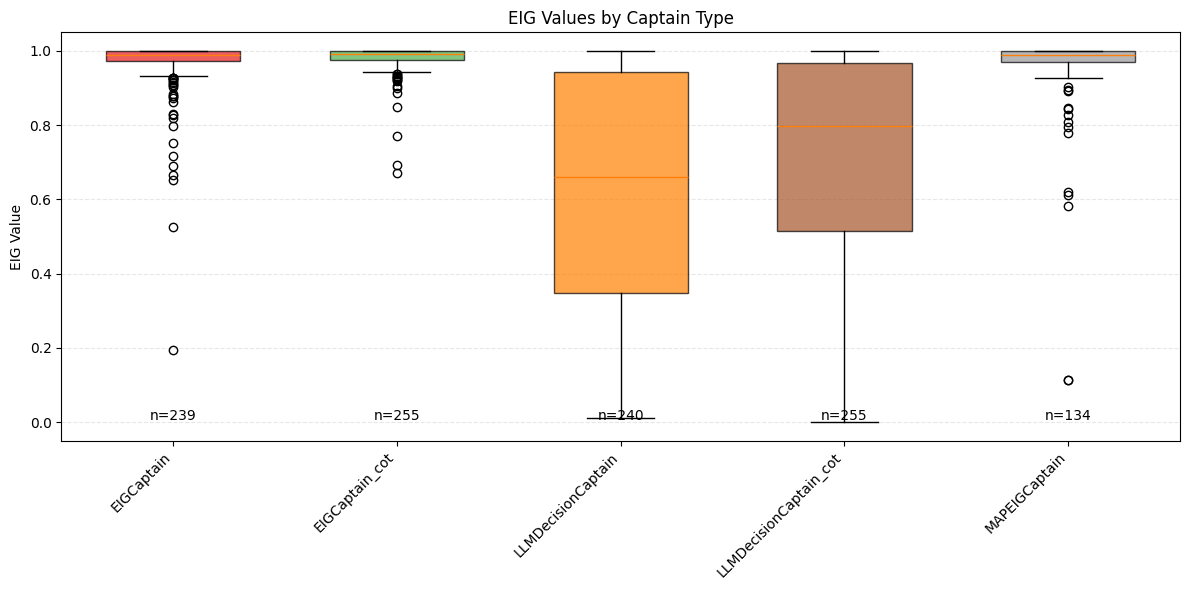

In [8]:
# Create a boxplot of EIG values divided by captain type
plt.figure(figsize=(12, 6))

# Filter out any remaining EIG values over 1 (additional safety check)
filtered_merged_df = merged_df[merged_df['eig'] <= 1]

# Get all unique captain types from filtered data
captain_types = filtered_merged_df['captain_type'].unique()
n_types = len(captain_types)

# Prepare data for boxplot
box_data = []
colors = plt.cm.Set1(np.linspace(0, 1, n_types))  # Generate colors for each captain type

for captain_type in captain_types:
    captain_data = filtered_merged_df[filtered_merged_df['captain_type'] == captain_type]['eig']
    box_data.append(captain_data)

# Create boxplot
box = plt.boxplot(box_data, positions=range(n_types), widths=0.6, patch_artist=True)

# Color the boxes
for i, (patch, color) in enumerate(zip(box['boxes'], colors)):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Customize plot
plt.ylabel('EIG Value')
plt.title('EIG Values by Captain Type')
plt.xticks(range(n_types), captain_types, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add sample size information
for i, captain_type in enumerate(captain_types):
    n_samples = len(filtered_merged_df[filtered_merged_df['captain_type'] == captain_type])
    plt.text(i, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), 
             f'n={n_samples}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [5]:
from battleship.run_captain_benchmarks import rebuild_captain_summary_from_results
import pandas as pd

summary = rebuild_captain_summary_from_results("/home/ubuntu/new_battleship/battleship/experiments/collaborative/captain_benchmarks/run_for_fun")

summary_df = pd.DataFrame(summary)
summary_df

,captain_type,spotter_type,round_id,board_id,seed,hits,misses,is_won,question_count,precision,recall,f1_score
0,LLMDecisionCaptain_cot,Spotter,0d18eff5,B02,42,11,29,False,15,0.275000,0.916667,0.423077
1,LLMDecisionCaptain_cot,Spotter,b7bc1f5c,B05,42,15,8,True,15,0.652174,1.000000,0.789474
2,LLMDecisionCaptain,Spotter,efecb01d,B12,42,9,14,True,15,0.391304,1.000000,0.562500
3,EIGCaptain,Spotter,ad50cabf,B06,42,10,10,True,15,0.500000,1.000000,0.666667
4,LLMDecisionCaptain,Spotter,f4eb0ac4,B02,42,12,19,True,15,0.387097,1.000000,0.558140
...,...,...,...,...,...,...,...,...,...,...,...,...
109,EIGCaptain_cot,Spotter,a6aa601c,B15,42,11,3,True,15,0.785714,1.000000,0.880000
110,EIGCaptain_cot,Spotter,07ddfe67,B05,42,15,9,True,15,0.625000,1.000000,0.769231
111,EIGCaptain_cot,Spotter,053ffe7b,B07,42,11,3,True,15,0.785714,1.000000,0.880000
112,RandomCaptain,Spotter,f88fa1af,B17,42,8,32,False,0,0.200000,0.615385,0.301887


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'LLMDecisionCaptain_cot'),
  Text(1, 0, 'LLMDecisionCaptain'),
  Text(2, 0, 'EIGCaptain'),
  Text(3, 0, 'RandomCaptain'),
  Text(4, 0, 'MAPCaptain'),
  Text(5, 0, 'EIGCaptain_cot'),
  Text(6, 0, 'MAPEIGCaptain')])

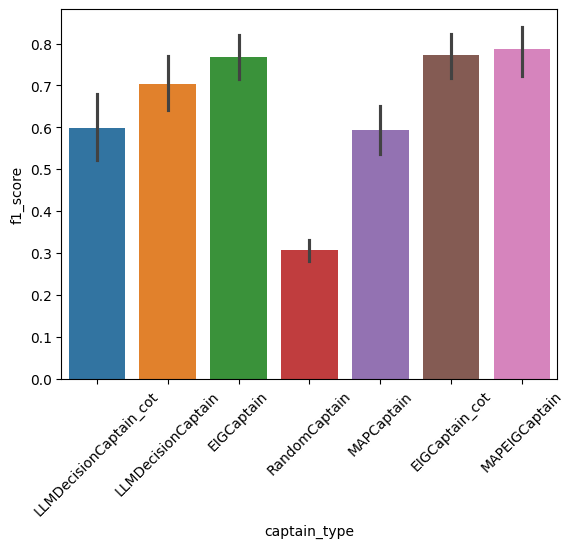

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=summary_df, x="captain_type", y="f1_score", hue="captain_type")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'LLMDecisionCaptain_cot'),
  Text(1, 0, 'MAPEIGCaptain'),
  Text(2, 0, 'EIGCaptain_cot'),
  Text(3, 0, 'LLMDecisionCaptain'),
  Text(4, 0, 'MAPEIGCaptain_cot'),
  Text(5, 0, 'EIGCaptain')])

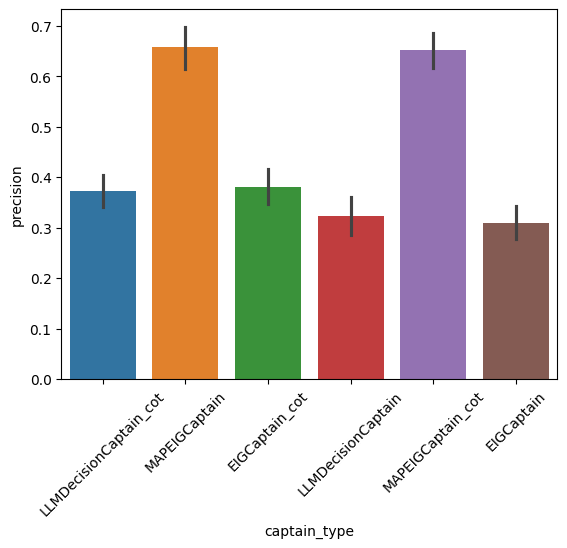

In [3]:
sns.barplot(data=summary_df, x="captain_type", y="precision", hue="captain_type")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'LLMDecisionCaptain_cot'),
  Text(1, 0, 'MAPEIGCaptain'),
  Text(2, 0, 'EIGCaptain_cot'),
  Text(3, 0, 'LLMDecisionCaptain'),
  Text(4, 0, 'MAPEIGCaptain_cot'),
  Text(5, 0, 'EIGCaptain')])

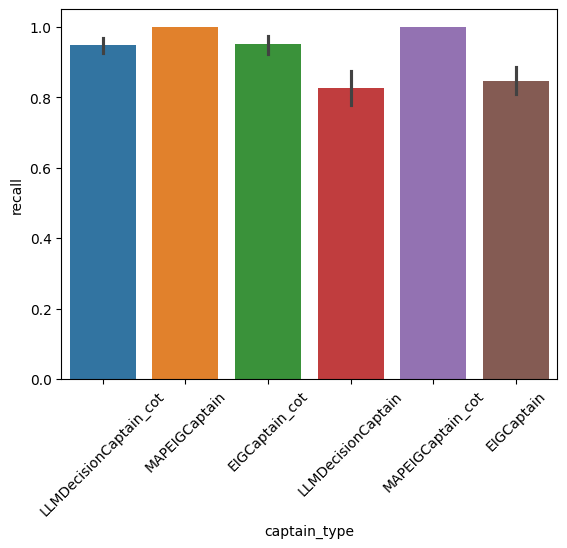

In [4]:
sns.barplot(data=summary_df, x="captain_type", y="recall", hue="captain_type")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'LLMDecisionCaptain_cot'),
  Text(1, 0, 'LLMDecisionCaptain'),
  Text(2, 0, 'EIGCaptain'),
  Text(3, 0, 'RandomCaptain'),
  Text(4, 0, 'MAPEIGCaptain'),
  Text(5, 0, 'MAPCaptain'),
  Text(6, 0, 'EIGCaptain_cot')])

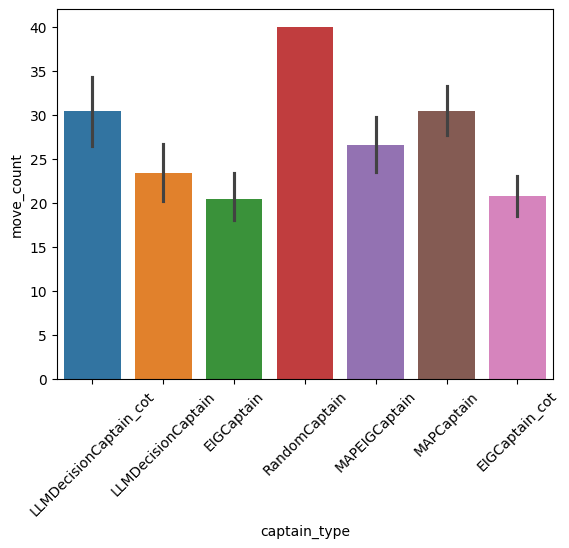

In [16]:
summary_df["move_count"] = summary_df["hits"] + summary_df["misses"]

sns.barplot(data=summary_df, x="captain_type", y="move_count", hue="captain_type")
plt.xticks(rotation=45)